Replaced embedding layer with GloVe word vectors.

In [17]:
# Clear all vars
%reset -f

## 1.0 Running on Colab / GCP / Local
If running on Colab, ensure the data is hosted on your Google drive in the identical directory structure as listed below.


In [18]:
import sys

# If running in Colab, change directory access paths
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    #Access google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')
    DIR_PREFIX = 'drive/My Drive/Colab Notebooks/image_caption/Data/'
else:
    DIR_PREFIX = './Data/'
print('IN_COLAB', IN_COLAB)
print('DIR_PREFIX', DIR_PREFIX)

# Init
GENERATE_FEATURES = False  #Set to True if features need to be generated through the underlying pre-trained net
LEARN = True  #Set to True if our custom net needs to learn the dataset
TL_MODEL = 'Inceptionv3'  #Pre-trained model used for recognizing obects within images. One of Inceptionv3 or VGG16 trained on ImageNet.
MAX_SAMPLES = -1  #Maximum number of samples to train & test with.

IN_COLAB False
DIR_PREFIX ./Data/


## Directories Required
Ensure you have the following directory structure no matter where you are hosting the data: GCP Storage, GCP Compute Engine local disk, Google Drive or your local desktop/laptop.

<div>
    <img src="https://drive.google.com/uc?id=1GDrk6lxt_AXAkU2jvv6kFGdnC1D4x1iq" alt="Broken URL. Contact Anand Menon." width="60%"/>
</div>

The root folder is 'image_caption'. The rest follow from it.<br/>
For Colab, there is one additional requirement. Ensure 'image_caption' is placed under 'Colab Notebooks' folder (which is created by Google automatically the first time you create a Colab notebook). Why? Since files within Google Colab are referenced with their full path starting all the way back to "drive".<br/>
For example:
filename = 'drive/My Drive/Colab Notebooks/Image Caption/Data/Flickr8k/Labels/Flickr_8K.token.txt'

## Files Required
The following files are required to run the code. All the files are shared, so you should ideally be able to copy the entire directory structure. Warning: It is over 2 GB, soon to be 10 GB.<br/>
You will need to recreate the folder structure locally (with files and all) since the code writes files back to it.

[Link to Data folder](https://drive.google.com/open?id=1bQtuMVTyaXCMGMC0XifOC2aKb1UGTSo6)

### Dataset Files: Train, test, validate
* Data/Flickr_8K/Images/Images/&lt;Images&gt;<br/>
<!-- <div>
    <img src="https://drive.google.com/uc?id=1le5RBL4d01JMch_lGJXQMYjRseX06m18" alt="Broken URL. Contact Anand Menon." width="40%"/>
</div>
 -->
* Data/Flickr_8K/Images/Labels/&lt;Labels&gt;<br/>
<!-- <div>
    <img src="https://drive.google.com/uc?id=1wXMKnKfbsixjJ41IQbJsVE7K1tCF-vfc" alt="Broken URL. Contact Anand Menon." width="40%"/>
</div>
 -->
 
### Word Vectors File

* Data/Flickr_8K/Images/Labels/&lt;Word vectors&gt;<br/>
You only need one of these depending upon how well trained the vectors need to be for your need. The 300D is better (and much bigger) than the 100D file.
    * glove.6B.100d.txt
    * glove.6B.300d.txt
<!-- <div>
    <img src="https://drive.google.com/uc?id=1-8Sdehe9n5TTHSurjbgn6P7jv8W-Bff_" alt="Broken URL. Contact Anand Menon." width="50%"/>
</div>
 -->



In [19]:
# Generate features via underlying pre-trained net
if GENERATE_FEATURES:
    from pickle import dump
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array
    from keras.models import Model
    from keras.utils import plot_model
    from os import listdir
    import time
    
    # Config
    if TL_MODEL == 'Inceptionv3':
        from keras.applications import InceptionV3
        from keras.applications.inception_v3 import preprocess_input
    else:        
        from keras.applications.vgg16 import VGG16
        from keras.applications.vgg16 import preprocess_input

    # Extract features from each photo in the directory
    def extract_features(directory):
        # Load Model
        if TL_MODEL == 'Inceptionv3':
            model = InceptionV3(include_top=True, weights='imagenet')
        else:
            model = VGG16(include_top=True, weights='imagenet')

        # Remove the top layer, retaining the features generated up-to the layer below
        model.layers.pop()
        model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
        print(model.summary())
        plot_model(model, to_file=DIR_PREFIX + 'Model/model_transfer_learning_'+TL_MODEL+'.png', show_shapes=True)

        # Extract features from each photo
        counter = 0
        features = dict()
        for name in listdir(directory):
            # Load an image from file
            filename = directory + '/' + name
            if TL_MODEL == 'Inceptionv3':
                image = load_img(filename, target_size=(299, 299), interpolation='bicubic')
            else:
                image = load_img(filename, target_size=(224, 224), interpolation='bicubic')
    
            # Reshape data for the model
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
            # Prepare image for the model
            image = preprocess_input(image)
    
            # Predict
            feature = model.predict(image, verbose=0)
            features[name] = feature
            if counter % 1000 == 0:
                print(counter, '%s' % name, time.time())
            counter += 1
        return features

    # Extract features from all images
    directory = DIR_PREFIX + 'Flickr_8K/Images'
    features = extract_features(directory)
    print('Extracted Features: %d' % len(features))

    # Save to file
    dump(features, open(DIR_PREFIX + 'Model/features_'+TL_MODEL+'.pkl', 'wb'))

In [20]:
#Load provided filename
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

#Load captions
filename = DIR_PREFIX + 'Flickr_8K/Labels/Flickr_8K.token.txt'
doc = load_doc(filename)
doc[0:333]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n10002682'

In [21]:
def extract_captions(doc):
    #Split on \n
    doc = doc.split('\n')

    #Split on id vs. description
    dictCaptions = {}  #Key = Photo identifier, Value = List of captions
    fullText = []  #For cleaning & reducing vocabulary size
    for line in doc:
        if line.strip() == '':
            continue
        tokens = line.split('\t')
        photo_id = tokens[0][0:-2]  #Up to .jpg
        photo_caption = tokens[1:][0].lower()  #Rest of words
        fullText.extend([photo_caption])
        if photo_id not in dictCaptions:
            dictCaptions[photo_id] = []
        dictCaptions[photo_id].extend([photo_caption])
    fullText = ' '.join(fullText)
    return dictCaptions, fullText

#Extract all words and captions
dictCaptions, fullText = extract_captions(doc)
print(len(dictCaptions))
print(len(fullText))
# print(dictCaptions)
fullText[0:333]

8092
2271131


'a child in a pink dress is climbing up a set of stairs in an entry way . a girl going into a wooden building . a little girl climbing into a wooden playhouse . a little girl climbing the stairs to her playhouse . a little girl in a pink dress going into a wooden cabin . a black dog and a spotted dog are fighting a black dog and a t'

In [22]:
#Check if gensim already exists
try:
    from gensim.parsing.preprocessing import strip_punctuation
except ImportError as e:
    !pip install gensim
    from gensim.parsing.preprocessing import strip_punctuation

#Remove punctuation
fullText_nopunc = strip_punctuation(fullText)
words = fullText_nopunc.split(' ')
numWords = len(words)
print(numWords)

518387


In [23]:
import random

#Count frequency of all words
dictWords = {}
for word in words:
    if word not in dictWords:
        dictWords[word] = 0
    dictWords[word] += 1
print(len(dictWords))
print(random.sample(list(dictWords.keys()), 10))

8489
['mess', 'takeing', 'bills', 'checkout', 'min', 'lesh', 'defenders', 'scarred', 'earflaps', 'trapped']


In [24]:
#Form dict of frequent words; in order to reduce vocabulary size
truncated = []
for word in words:
    if word in dictWords:
        if dictWords[word]/numWords > 0.00005:  #0.005%
            truncated.append(word)
print(len(words))
print(len(truncated))

dictWordsTrunc = {}
for word in truncated:
    if word not in dictWordsTrunc:
        dictWordsTrunc[word] = 0
    dictWordsTrunc[word] += 1
print(len(dictWordsTrunc))
list(dictWordsTrunc.keys())[0:10]

518387
488975
1106


['a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of']

In [25]:
# Drop infrequent words from captions, reducing vocabulary size
def drop_infrequent(dictCaptions):
    dictTemp = {}
    for id, captions in dictCaptions.items():
        if id not in dictTemp:
            dictTemp[id] = []
        for caption in captions:
            newCaption = []
            for word in caption.split(' '):
                if word in dictWordsTrunc:
                    newCaption.append(word)
            newCaption = ' '.join(newCaption)
            dictTemp[id].append(newCaption)
    return dictTemp
 
#Drop infrequent words
descriptions = drop_infrequent(dictCaptions)
print('Total samples: %d ' % len(descriptions))

Total samples: 8092 


In [26]:
import numpy as np
from numpy import array
from pickle import dump
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# load a pre-defined list of photo identifiers
def load_set(filename, max_samples=-1):
    doc = load_doc(filename)
    dataset = list()
    counter = 0
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        dataset.append(line)
        if (max_samples > -1) and (counter > max_samples):
            break
        counter += 1
    print('\tLines loaded:', counter)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(all_descriptions, dataset):
    descriptions = dict()
    for image_id,image_desc_list in all_descriptions.items():
        if image_id not in dataset: 
            continue;  #Skip if not in list of dataset id's
        if image_id not in descriptions:
            descriptions[image_id] = list()
        # print(image_id, image_desc_list)
        for image_desc in image_desc_list:
            # print('\t', image_desc)
            desc = 'startseq ' + image_desc + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

# train dataset

# load training dataset (6K)
filename = DIR_PREFIX + 'Flickr_8K/Labels/Flickr_8K.trainImages.txt'
train = load_set(filename, MAX_SAMPLES)

# descriptions
train_descriptions = load_clean_descriptions(descriptions, train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features(DIR_PREFIX + 'Model/features_'+TL_MODEL+'.pkl', train)
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)

# save the tokenizer
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
max_length = max_length(train_descriptions)

print('Max Description Length: %d' % max_length)
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
print(X1train.shape)
print(X2train.shape)
print(ytrain.shape)

# dev dataset

# load test set
filename = DIR_PREFIX + 'Flickr_8K/Labels/Flickr_8K.devImages.txt'
test = load_set(filename, MAX_SAMPLES)
print('Dataset: %d' % len(test))

# descriptions
test_descriptions = load_clean_descriptions(descriptions, test)
print('Descriptions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features(DIR_PREFIX + 'Model/features_'+TL_MODEL+'.pkl', test)
print('Photos: test=%d' % len(test_features))

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)
print(X1test.shape)
print(X2test.shape)
print(ytest.shape)

	Lines loaded: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 1107
Max Description Length: 34
(331508, 2048)
(331508, 34)
(331508, 1107)
	Lines loaded: 1000
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
(55678, 2048)
(55678, 34)
(55678, 1107)


## Create & Run Model

In [27]:
import os
import sys

if LEARN:
    #Load GloVe word vectors
    GLOVE_DIR = DIR_PREFIX + 'Vectors/'

    #Create embedding matrix
    EMBEDDING_DIM = 300

    embeddings_index = {}
    if (EMBEDDING_DIM == 100):
        embedding_filename = 'glove.6B.100d.txt'
    else:
        embedding_filename = 'glove.6B.300d.txt'
    f = open(os.path.join(GLOVE_DIR, embedding_filename))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print(embedding_matrix.shape)

Found 400000 word vectors.
(1107, 300)


In [28]:
if LEARN:
    from keras.utils import plot_model
    from keras.models import Model
    from keras.layers import Input
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Embedding
    from keras.layers import Dropout
    from keras.layers.merge import add
    from keras.callbacks import ModelCheckpoint

    # define the captioning model
    def define_model(vocab_size, max_length):
        # feature extractor model
        if TL_MODEL == 'Inceptionv3':
            inputs1 = Input(shape=(2048,))
        else:
            inputs1 = Input(shape=(4096,))
        fe1 = inputs1  #Dropout(0.2)(inputs1)
        fe2 = Dense(300, activation='relu')(fe1)
        
        # sequence model
        inputs2 = Input(shape=(max_length,))
        # se1 = Embedding(vocab_size, 300, mask_zero=True)(inputs2)
        se1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
        se2 = se1  #Dropout(0.2)(se1)
        se3 = LSTM(300)(se2)

        # decoder model
        decoder1 = add([fe2, se3])
        decoder2 = Dense(300, activation='relu')(decoder1)
        outputs = Dense(vocab_size, activation='softmax')(decoder2)
        
        # tie it together [image, seq] [word]
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        
        # summarize model
        print(model.summary())
        print(DIR_PREFIX + 'Model/model_custom_'+TL_MODEL+'.png')
        plot_model(model, to_file=DIR_PREFIX + 'Model/model_custom_'+TL_MODEL+'.png', show_shapes=True)
        return model

    # fit model

    # define the model
    model = define_model(vocab_size, max_length)

    # define checkpoint callback
    filepath = DIR_PREFIX + 'Weights/weights.best_'+TL_MODEL+'.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # fit model
    model.fit([X1train, X2train], ytrain, epochs=3, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      332100      input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          614700      input_4[0][0]                    
____________________________________________________________________________________________

## Model Evaluation

In [29]:
from numpy import argmax
from keras.models import load_model
from keras.models import Model
from keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)

        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load the model
filename = DIR_PREFIX + 'Weights/weights.best_'+TL_MODEL+'.hdf5'
model_custom_from_weights = load_model(filename)
print(model_custom_from_weights.summary())
plot_model(model_custom_from_weights, to_file=DIR_PREFIX + 'Model/model_custom_from_weights_'+TL_MODEL+'.png', show_shapes=True)

# evaluate model
evaluate_model(model_custom_from_weights, test_descriptions, test_features, tokenizer, max_length)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      332100      input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 300)          614700      input_4[0][0]                    
____________________________________________________________________________________________

In [30]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

#Config model imports
if TL_MODEL == 'Inceptionv3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input
else:
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

# extract features from each photo in the directory
def extract_features(model, filename):
    # load the photo
    if TL_MODEL == 'Inceptionv3':
        image = load_img(filename, target_size=(299, 299), interpolation='bicubic')
    else:
        image = load_img(filename, target_size=(224, 224))

    # convert the image pixels to a numpy array
    image = img_to_array(image)

    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # prepare the image for the model
    image = preprocess_input(image)
    
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# Load Model
if TL_MODEL == 'Inceptionv3':
    model_TL = InceptionV3(include_top=True, weights='imagenet')
else:
    model_TL = VGG16(include_top=True, weights='imagenet')

# re-structure the model
model_TL.layers.pop()
model_TL = Model(inputs=model_TL.inputs, outputs=model_TL.layers[-1].output)
print('Done')

Done


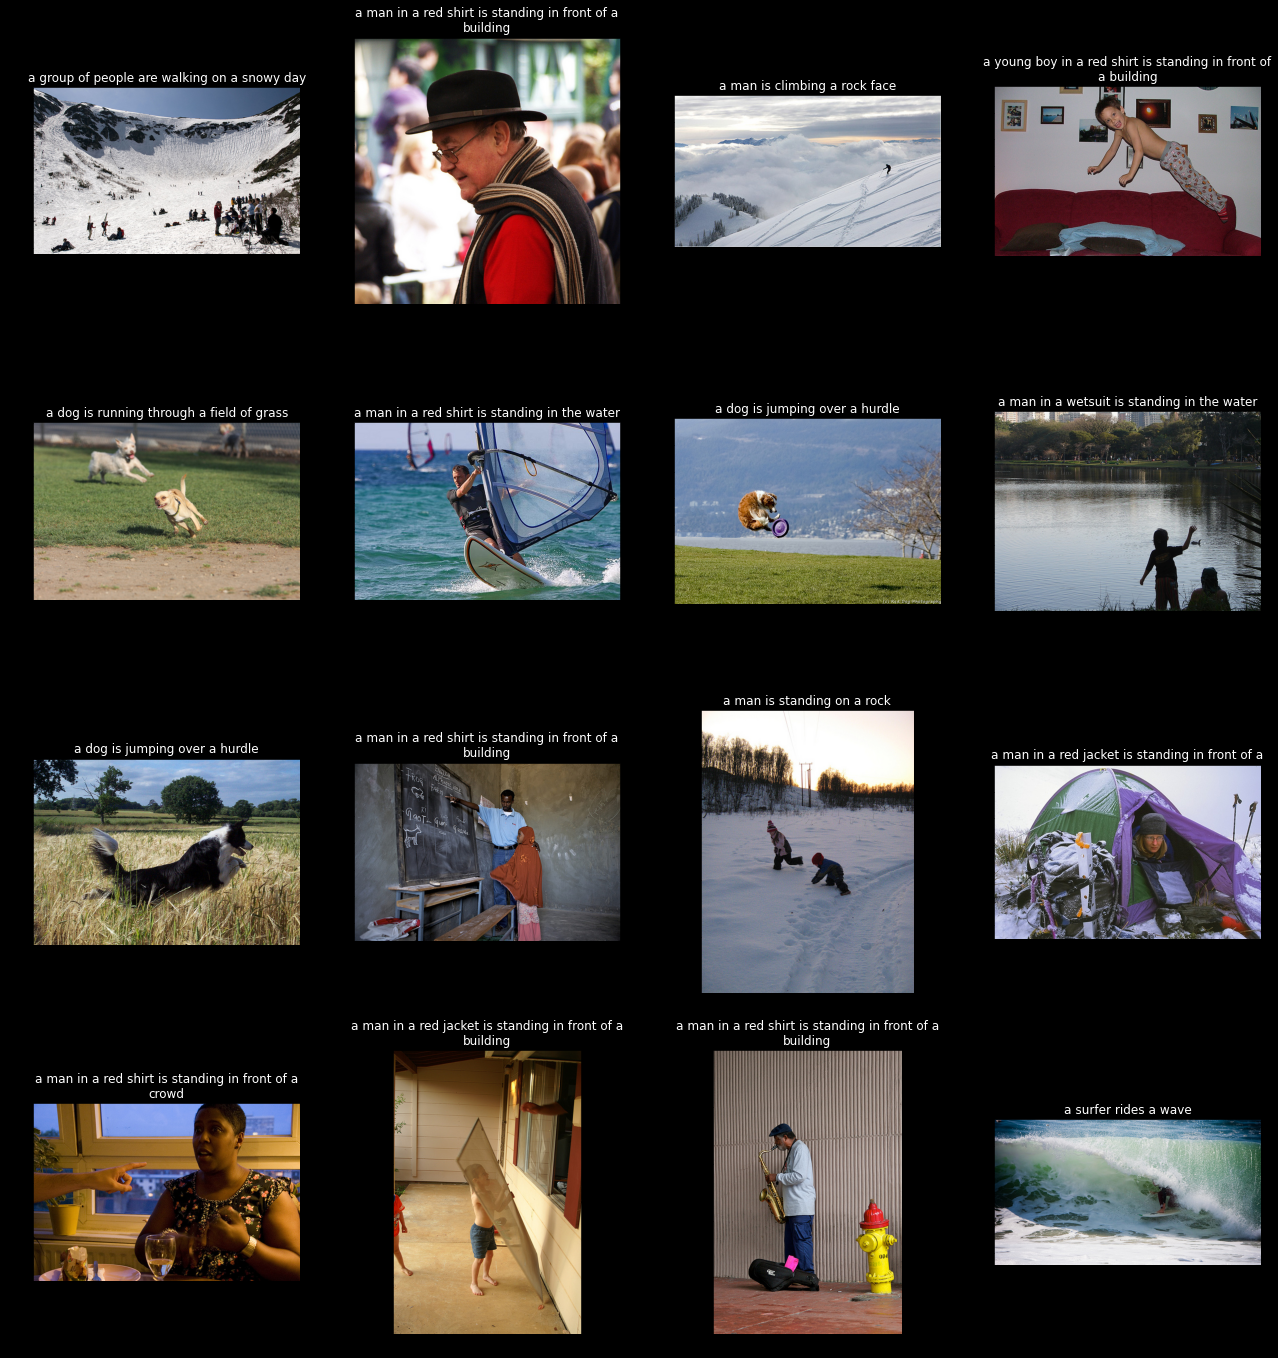

In [31]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from textwrap import wrap

#Get random images
testIDs = random.sample(test, 16)
# testIDs = [id.split('_')[0] + '.' + id.split('_')[1].split('.')[1] for id in testIDs]

plt.rcParams['figure.facecolor'] = 'black'
fig=plt.figure(figsize=(22, 24))
fig.patch.set_facecolor('black')
columns = 4
rows = 4
for i in range(1, columns*rows+1):
    #Predict description
    photo = extract_features(model_TL, DIR_PREFIX + 'Flickr_8K/Images/'+testIDs[i-1])
    description = generate_desc(model_custom_from_weights, tokenizer, photo, max_length)
    description = description.replace('startseq ', '').replace(' endseq', '')

    #Plot image and description together
    img = mpimg.imread(DIR_PREFIX + 'Flickr_8K/Images/'+testIDs[i-1])
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title("\n".join(wrap(description, 50)), color='white')
    ax.set_facecolor('xkcd:black')
    plt.imshow(img)
plt.savefig(DIR_PREFIX + 'Model/results_'+TL_MODEL+'_'+datetime.today().strftime('%Y-%m-%d-%H:%M:%S'), bbox_inches='tight', facecolor='black', dpi = 50)
plt.show()